# Batch Reset Hyperparameter Tutorial

When training data are very long, a stateful model is prone to instability since at the early iterations of training, an unreasonable hidden state is generated and propogated through many batches of training.

We introduce the hyperparameter `batch_reset`, which resets the hidden state after a fixed number of batches. Future work will make this a schedule where the number of batches before reset is increased as the network learns and will be less subject to exploding/vanishing gradients.

## Environment and Data Setup

In [1]:
# Environment
import os
import os.path as osp
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
# Local modules
sys.path.append('..')
import reproducibility
from utils import print_dict_summary
from data_funcs import rmse
from moisture_rnn import RNNParams, RNNData, RNN
from moisture_rnn_pkl import pkl2train
from utils import read_yml, read_pkl
import yaml
import pickle

In [2]:
dat = read_pkl("batch_reset_tutorial_case.pkl")

loading file batch_reset_tutorial_case.pkl


In [3]:
params = read_yml("../params.yaml", subkey="rnn")
params = RNNParams(params)
params.update({'epochs': 10})

Checking params...
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'rain']
Input Timesteps: 5
Input Batch Size: 32
Calculated params:
Number of features: 3
Batch Shape: (32, 5, 3)
{'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 20, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_fracs': [0.9, 0.05, 0.05], 'early_stopping_patience': 5, 'predict_spinup_hours': 5, 'n_features': 3, 'batch_shape': (32, 5, 3)}


In [4]:
rnn_dat = RNNData(dat, scaler = params['scaler'], features_list = params['features_list'])
rnn_dat.train_test_split(
    time_fracs = [.9, .05, .05]
)
rnn_dat.scale_data()
rnn_dat.batch_reshape(timesteps = params['timesteps'], batch_size = params['batch_size'])

Input data is single timeseries.
Setting data scaler: standard
Subsetting input data to features_list: ['Ed', 'Ew', 'rain']
Train index: 0 to 3283
Validation index: 3283 to 3465
Test index: 3465 to 3648
X_train shape: (3283, 3), y_train shape: (3283, 1)
X_val shape: (182, 3), y_val shape: (182, 1)
X_test shape: (183, 3), y_test shape: (183, 1)
Scaling training data with scaler StandardScaler(), fitting on X_train
Reshaping training data using batch size: 32 and timesteps: 5
Reshaping validation data using batch size: 32 and timesteps: 5


## Train without Stateful

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f
Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 200, 'epochs': 10, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': False, 'verbose_weights': True, 'verbose_fit': True, '

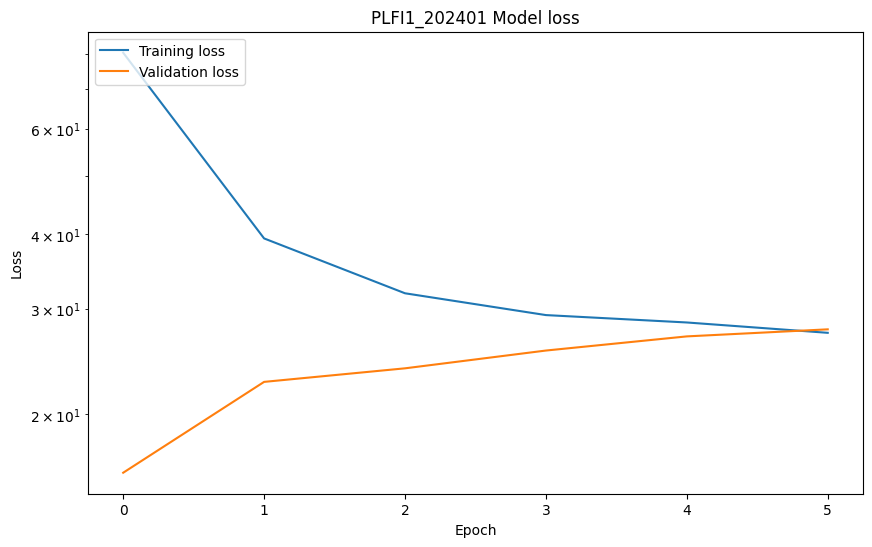

Fitted Weights Hash: 707c3ce7772f5ef34ea2b8c9e891be14
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Predictions Hash: 1d6656029550763be19e4dc16130798c
**************************************************
Caught Error Input contains NaN.
**************************************************


In [5]:
params.update({'verbose_fit': True, 'stateful': False, 'batch_reset':9999})
reproducibility.set_seed(123)
rnn = RNN(params)
try:
    m, errs = rnn.run_model(rnn_dat)
except Exception as e:
    print("*"*50)
    print(f"Caught Error {e}")
    print("*"*50)

In [6]:
rnn.predict(rnn_dat.scale_all_X())[0:150]

Scaling all X data with scaler StandardScaler(), fitted on X_train
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([4.19447470e+00, 6.21630096e+00, 9.13594723e+00, 1.23229008e+01,
       1.64470196e+01, 1.98027973e+01, 2.40429420e+01, 2.76067905e+01,
       3.19270191e+01, 3.65502319e+01, 4.18474388e+01, 4.69655533e+01,
       5.35034599e+01, 5.98920441e+01, 6.68283844e+01, 7.40816345e+01,
       8.21947632e+01, 9.01180573e+01, 1.00308914e+02, 1.10547462e+02,
       1.21547035e+02, 1.33639786e+02, 1.47417160e+02, 1.61358322e+02,
       1.77417145e+02, 1.93668045e+02, 2.11403793e+02, 2.30844650e+02,
       2.52188675e+02, 2.74613251e+02, 3.00193390e+02, 3.27632294e+02,
       3.57804962e+02, 3.90261261e+02, 4.25839996e+02, 4.63622498e+02,
       5.05584595e+02, 5.50832153e+02, 6.00328613e+02, 6.53918274e+02,
       7.13525208e+02, 7.77433777e+02, 8.47976990e+02, 9.24023987e+02,
       1.00707990e+03, 1.09691663e+03, 1.19553467e+03, 1.30174963e+03,
       1.41806677e+03, 1.54427942e+03, 1.68238025e+03, 1.83174670e+03,
       1.99566321e+03, 2.17277515e+03, 2.36626489e+03, 2.57606616e+03,
      

## Train with Stateful, without Batch Reset

We turn off the parameter by setting it to a huge value.

In [7]:
params.update({'verbose_fit': True, 'stateful': True, 'batch_schedule_type':None})
params.update({'epochs': 30})
reproducibility.set_seed(123)
rnn = RNN(params)

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f


Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': None, 'bmin': 20, 'bmax': 200, 'epochs': 30, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': True, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_fracs'

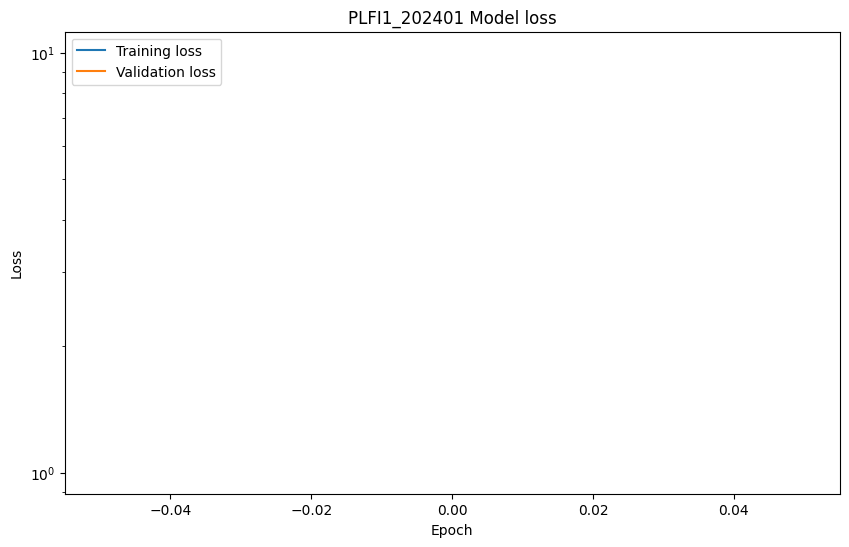

Fitted Weights Hash: 0f9f0ceb46568358da0e89dda4e1895c
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predictions Hash: 2f2419358dc0b3af94a71adbe7745ddd
**************************************************
Caught Error Input contains NaN.
**************************************************


In [8]:
try:
    m, errs = rnn.run_model(rnn_dat)
except Exception as e:
    print("*"*50)
    print(f"Caught Error {e}")
    print("*"*50)

## Train with Stateful, with Periodic Batch Reset

In [9]:
params.update({'verbose_fit': True, 'stateful': True, 'batch_schedule_type':'constant', 'bmin': 20})
params.update({'epochs': 30})
reproducibility.set_seed(123)
rnn = RNN(params)

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f


Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'constant', 'bmin': 20, 'bmax': 200, 'epochs': 30, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': True, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'standard', 'time_

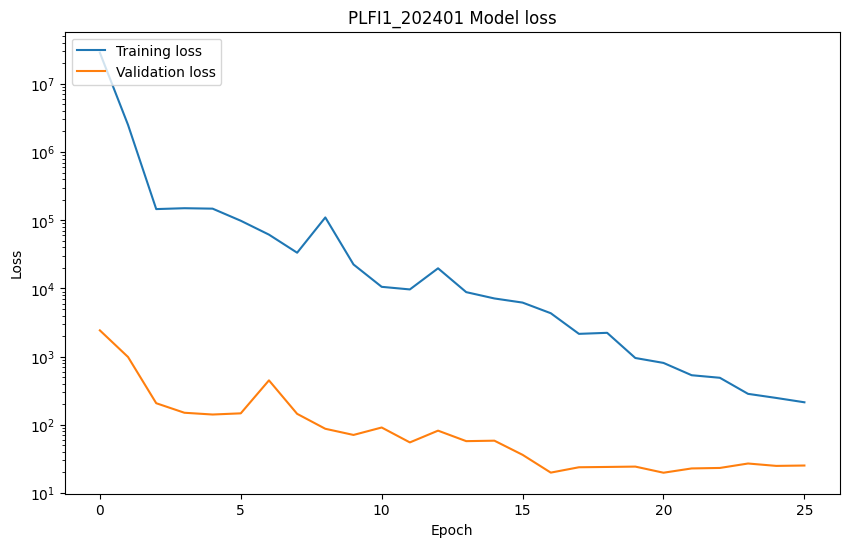

Fitted Weights Hash: c43012471b0d83287db5b55afd4cbe0c
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predictions Hash: d8faeac755ea13940c184728386d4a7e


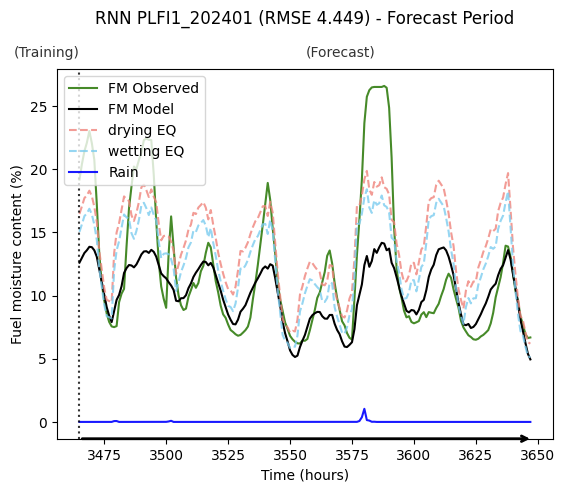

In [10]:
try:
    m, errs = rnn.run_model(rnn_dat, plot_period="predict")
except Exception as e:
    print("*"*50)
    print(f"Caught Error {e}")
    print("*"*50)

## Batch Reset Schedules

In [11]:
from moisture_rnn import calc_exp_intervals, calc_log_intervals

In [12]:
epochs = 50
bmin = 10
bmax = 200

egrid = np.arange(epochs)

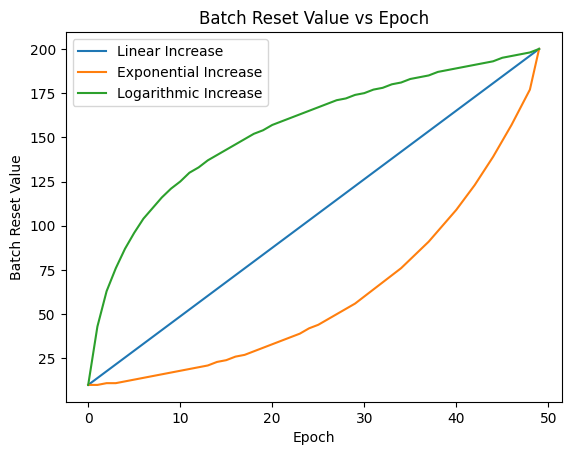

In [13]:
plt.plot(egrid, np.linspace(bmin, bmax, epochs), label='Linear Increase')
plt.plot(egrid, calc_exp_intervals(bmin, bmax, epochs), label='Exponential Increase')
plt.plot(egrid, calc_log_intervals(bmin, bmax, epochs), label='Logarithmic Increase')
plt.xlabel('Epoch')
plt.ylabel('Batch Reset Value')
plt.legend()
plt.title('Batch Reset Value vs Epoch')
plt.show()

### Linear Schedule

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f
Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'linear', 'bmin': 20, 'bmax': 3648, 'epochs': 40, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': Fals

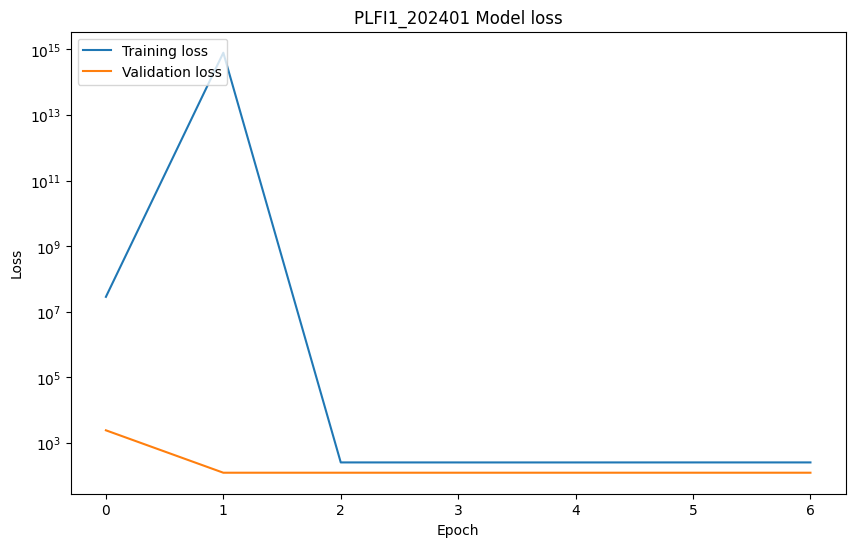

Fitted Weights Hash: 15458c797e0f4fde9dcaa85f7982de3b
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predictions Hash: d0317a55dcb74b7679fc75ef3f7587c0


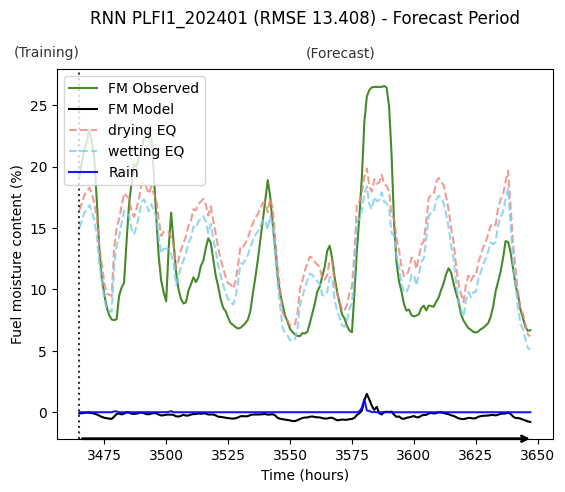

In [14]:
params.update({'verbose_fit': False, 'stateful': True, 
               'batch_schedule_type':'linear', 'bmin': 20, 'bmax': rnn_dat.hours})
params.update({'epochs': 40})
reproducibility.set_seed(123)
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat, plot_period = "predict")

### Exponential Increase

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f
Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'exp', 'bmin': 20, 'bmax': 3648, 'epochs': 40, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 

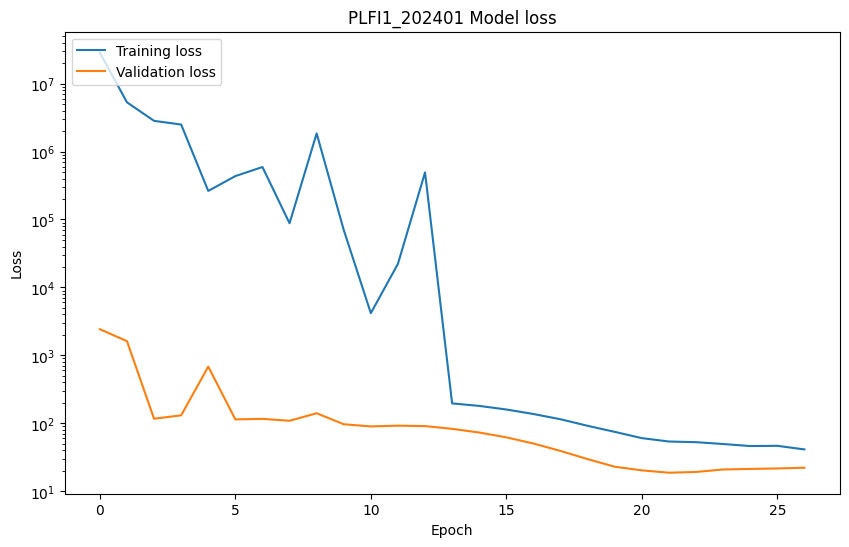

Fitted Weights Hash: 7275cc04fba55a1a8def380f6d1d43e3
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Predictions Hash: c7c4620d2f039e6b294fd1ddae95b16e


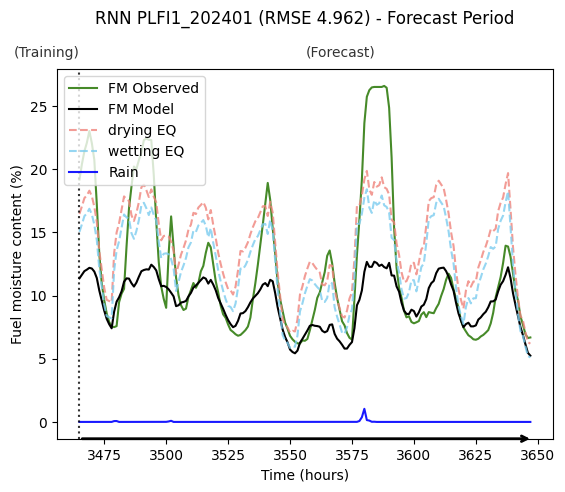

In [15]:
params.update({'verbose_fit': False, 'stateful': True, 
               'batch_schedule_type':'exp', 'bmin': 20, 'bmax': rnn_dat.hours})
params.update({'epochs': 40})
reproducibility.set_seed(123)
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat, plot_period = "predict")

### Log Increase

resetting random seeds to 123
Initial Weights Hash: 9ffdefb2c67cfc3b020467a90ca9394f
Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: dd022ea058b5527cf238fe82cf0961ec
Hash of y: 8f4ce93354809be3017b349248c6a2d5
Hash of X_train: 59f3a4c97d76ad86fa44191daff325d6
Hash of y_train: b5ee999686d5aaca5ddddd7756ad19cb
Hash of X_val: 4026c974c69a6eb650bd79ea2aafd527
Hash of y_val: 12dfbe7c975275d63116988d4c9e8362
Hash of X_test: 2fa2f4b62e901d809a8d6d0e5b68c9cc
Hash of y_test: 9de6803fd71b9cd4e7422d026cf3863a
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_schedule_type': 'log', 'bmin': 20, 'bmax': 3648, 'epochs': 40, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 

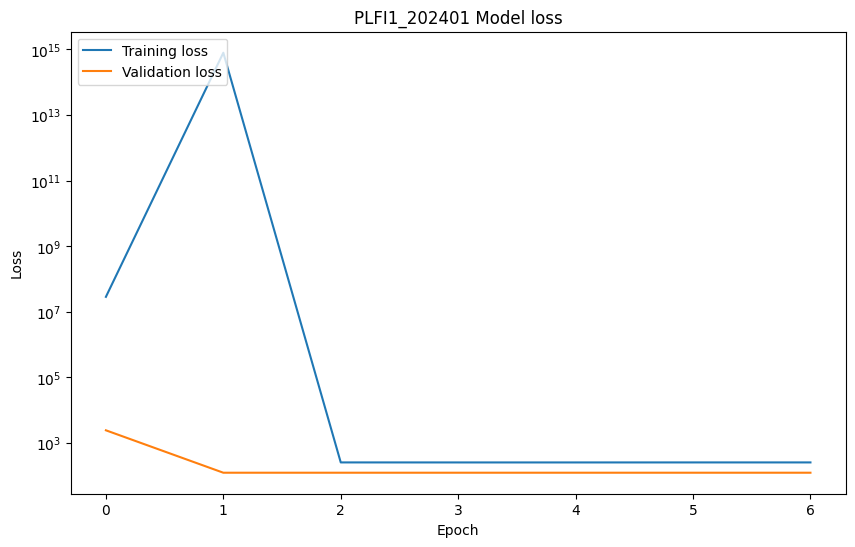

Fitted Weights Hash: 6cad5c92c0d2b46d36fb76ad1a4116a7
Running prediction on all input data, Training through Test
Scaling all X data with scaler StandardScaler(), fitted on X_train
All X hash: 03c2e9bf756cd8f674037c35ff1c76a7
Predicting test data
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predictions Hash: 77f6fcce7c7078e2251583c20a0b54ab


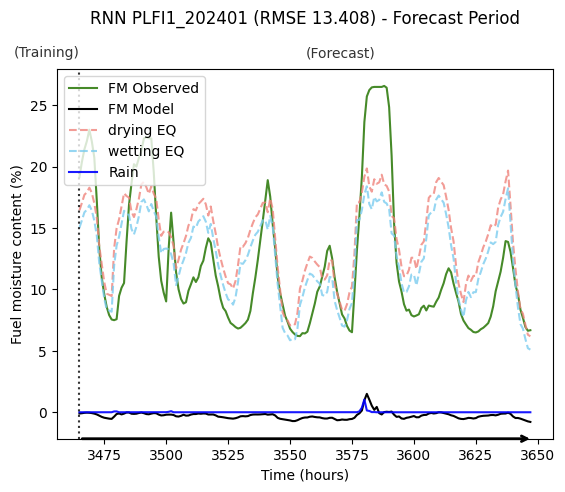

In [16]:
params.update({'verbose_fit': False, 'stateful': True, 
               'batch_schedule_type':'log', 'bmin': 20, 'bmax': rnn_dat.hours})
params.update({'epochs': 40})
reproducibility.set_seed(123)
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat, plot_period = "predict")